<a href="https://colab.research.google.com/github/BehnoodRasti/Unmixing_Tutorial_IEEE_IADF/blob/main/CNNAEU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Blind Unmixing - CNNAEU

---

original implementation found at https://github.com/burknipalsson/hu_autoencoders/blob/main/Method_CNNAEU.ipynb

## Implementation of method CNNAEU
Published in

B. Palsson, M. O. Ulfarsson and J. R. Sveinsson, "Convolutional Autoencoder for Spectral–Spatial Hyperspectral Unmixing," in IEEE Transactions on Geoscience and Remote Sensing, vol. 59, no. 1, pp. 535-549, Jan. 2021, doi: 10.1109/TGRS.2020.2992743.

## Imports

---

In [1]:
!git clone https://github.com/BehnoodRasti/Unmixing_Tutorial_IEEE_IADF.git

Cloning into 'Unmixing_Tutorial_IEEE_IADF'...
remote: Enumerating objects: 124, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 124 (delta 55), reused 29 (delta 7), pack-reused 0
Receiving objects: 100% (124/124), 35.30 MiB | 11.52 MiB/s, done.
Resolving deltas: 100% (55/55), done.


In [2]:
!pip install munkres

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import tensorflow as tf
from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()
from scipy import io as sio
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
%matplotlib inline

from mpl_toolkits.axes_grid1 import make_axes_locatable
import os


from tensorflow.keras import Model, Sequential, layers, optimizers, activations
from sklearn.feature_extraction.image import extract_patches_2d
import shutil

2023-01-03 16:09:09.924810: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-03 16:09:10.420417: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/azouaoui/local/lib:
2023-01-03 16:09:10.420442: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-03 16:09:12.492720: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared 

ModuleNotFoundError: No module named 'sklearn'

In [24]:
from Unmixing_Tutorial_IEEE_IADF.utils.data import HSI
from Unmixing_Tutorial_IEEE_IADF.utils.metrics import MeanSquareError as MSE
from Unmixing_Tutorial_IEEE_IADF.utils.metrics import aRMSE as RMSE
from Unmixing_Tutorial_IEEE_IADF.utils.metrics import SADDegrees as SADMetric 
from Unmixing_Tutorial_IEEE_IADF.utils.aligners import MunkresAbundancesAligner as Aligner

## Use GPU

In [5]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

## Method training_input_fn
Extracts patches for training 

In [7]:
def training_input_fn(hsi, patch_size, patch_number, batch_size):
    patches = extract_patches_2d(hsi, (patch_size, patch_size), max_patches=patch_number)
    return patches

## Class SumToOne
Enforces the ASC. Regularizations on the abundance maps go in here. 

In [8]:
class SumToOne(tf.keras.layers.Layer):
    def __init__(self, params, **kwargs):
        super(SumToOne, self).__init__(**kwargs)
        self.num_outputs = params['num_endmembers']
        self.params = params
    
    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]
        
    def call(self, x):
        x = tf.nn.softmax(self.params['scale'] * x)
        return x

## Class Encoder
Extends the Model class. Encodes input patches

In [9]:
class Encoder(tf.keras.Model):
    def __init__(self, params):
        super(Encoder, self).__init__()
        self.params = params
        self.hidden_layer_one = tf.keras.layers.Conv2D(filters=self.params['e_filters'],
                                                       kernel_size=self.params['e_size'],
                                                       activation=self.params['activation'], strides=1, padding='same',
                                                       kernel_initializer=params['initializer'], use_bias=False)
        self.hidden_layer_two = tf.keras.layers.Conv2D(filters=self.params['num_endmembers'], kernel_size=1,
                                                       activation=self.params['activation'], strides=1, padding='same',
                                                       kernel_initializer=self.params['initializer'], use_bias=False)
        self.asc_layer = SumToOne(params=self.params, name='abundances')

    def call(self, input_patch):
        code = self.hidden_layer_one(input_patch)
        code = tf.keras.layers.BatchNormalization()(code)
        code = tf.keras.layers.SpatialDropout2D(0.2)(code)
        code = self.hidden_layer_two(code)
        code = tf.keras.layers.BatchNormalization()(code)
        code = tf.keras.layers.SpatialDropout2D(0.2)(code)
        code = self.asc_layer(code)
        return code

## Class Decoder
Extends the Layer class. Decodes abundance patches and reconstructs the inputs to the encoder.

In [10]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, params):
        super(Decoder, self).__init__()
        self.output_layer = tf.keras.layers.Conv2D(filters=params['d_filters'], kernel_size=params['d_size'],
                                                   activation='linear',
                                                   kernel_constraint=tf.keras.constraints.non_neg(),
                                                   name='endmembers', strides=1, padding='same',
                                                   kernel_regularizer=None,
                                                   kernel_initializer=params['initializer'], use_bias=False)

    def call(self, code):
        recon = self.output_layer(code)
        return recon

    def getEndmembers(self):
        return self.output_layer.get_weights()

## Class Autoencoder
Extends the Model class 

In [11]:
class Autoencoder(tf.keras.Model):
    def __init__(self, params):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(params)
        self.decoder = Decoder(params)
        self.params = params

    def call(self, patch):
        abunds = self.encoder(patch)
        # tf.summary.histogram('abunds', abunds, step=1)
        #         abunds = tf.keras.layers.SpatialDropout2D(0.08)(abunds)
        output = self.decoder(abunds)
        return output

    def getEndmembers(self):
        endmembers = self.decoder.getEndmembers()[0]
        if endmembers.shape[1] > 1:
            endmembers = np.squeeze(endmembers).mean(axis=0).mean(axis=0)
        else:
            endmembers = np.squeeze(endmembers)
        return endmembers

    def getAbundances(self, hsi):
        return np.squeeze(self.encoder.predict(np.expand_dims(hsi, 0)))

    def train(self, patches, callback):
        self.plotWhileTraining = callback
        self.fit(patches, patches, epochs=self.params['epochs'], batch_size=self.params['batch_size'],
                 callbacks=[self.plotWhileTraining], verbose=0)

    def saveResults(self, fname):
        endmembers = self.getEndmembers()
        abundances = self.getAbundances(params['data'])
        sads = self.plotWhileTraining.sads
        sio.savemat(fname, {'M': endmembers, 'A': abundances, 'sads': sads})

## SAD and Loss functions

In [12]:
def SAD(y_true, y_pred):
    y_true = tf.math.l2_normalize(y_true, axis=-1)
    y_pred = tf.math.l2_normalize(y_pred, axis=-1)
    A = (y_true * y_pred)
    sad = tf.math.acos(A)
    return sad

def numpy_SAD(y_true, y_pred):
    return np.arccos(y_pred.dot(y_true) / (np.linalg.norm(y_true) * np.linalg.norm(y_pred)))


def loss(model, original):
    reconstruction_error = SAD(model(original), original)
    return reconstruction_error

## Various functions for training and plotting

In [13]:
def train(loss, model, opt, original):
    with tf.GradientTape() as tape:
        gradients = tape.gradient(loss(model, original) + sum(model.losses), model.trainable_variables)
        gradient_variables = zip(gradients, model.trainable_variables)
        opt.apply_gradients(gradient_variables)


def order_endmembers(endmembers, endmembersGT):
    num_endmembers = endmembers.shape[0]
    dict = {}
    sad_mat = np.ones((num_endmembers, num_endmembers))
    for i in range(num_endmembers):
        endmembers[i, :] = endmembers[i, :] / endmembers[i, :].max()
        endmembersGT[i, :] = endmembersGT[i, :] / endmembersGT[i, :].max()
    for i in range(num_endmembers):
        for j in range(num_endmembers):
            sad_mat[i, j] = numpy_SAD(endmembers[i, :], endmembersGT[j, :])
    rows = 0
    while rows < num_endmembers:
        minimum = sad_mat.min()
        index_arr = np.where(sad_mat == minimum)
        if len(index_arr) < 2:
            break
        index = (index_arr[0][0], index_arr[1][0])
        if index[0] in dict.keys():
            sad_mat[index[0], index[1]] = 100
        elif index[1] in dict.values():
            sad_mat[index[0], index[1]] = 100
        else:
            dict[index[0]] = index[1]
            sad_mat[index[0], index[1]] = 100
            rows += 1
    ASAM = 0
    num = 0
    for i in range(num_endmembers):
        if np.var(endmembersGT[dict[i]]) > 0:
            ASAM = ASAM + numpy_SAD(endmembers[i, :], endmembersGT[dict[i]])
            num += 1

    return dict, ASAM / float(num)


def plotEndmembers(endmembers):
    endmembers = endmembers / endmembers.max()
    fig = plt.figure(1)
    for i in range(num_endmembers):
        ax = plt.subplot(2, 2, i + 1)
        plt.plot(endmembers[i, :], 'r', linewidth=1.0)
        ax.get_xaxis().set_visible(False)
    plt.tight_layout()
    plt.show()


def plotEndmembersAndGT(endmembers, endmembersGT):
    num_endmembers = endmembers.shape[0]
    n = num_endmembers // 2  # how many digits we will display
    if num_endmembers % 2 != 0: n = n + 1
    dict, sad = order_endmembers(endmembers, endmembersGT)

    fig = plt.figure(num=1, figsize=(8, 8))
    plt.clf()
    title = "aSAM score for all endmembers: " + format(sad, '.3f') + " radians"
    st = plt.suptitle(title)
    for i in range(num_endmembers):
        endmembers[i, :] = endmembers[i, :] / endmembers[i, :].max()
        endmembersGT[i, :] = endmembersGT[i, :] / endmembersGT[i, :].max()

    for i in range(num_endmembers):
        ax = plt.subplot(2, n, i + 1)
        plt.plot(endmembers[i, :], 'r', linewidth=1.0)
        plt.plot(endmembersGT[dict[i], :], 'k', linewidth=1.0)
        ax.set_title("SAD: " + str(i) + " :" + format(numpy_SAD(endmembers[i, :], endmembersGT[dict[i], :]), '.4f'))
        ax.get_xaxis().set_visible(False)

    plt.tight_layout()
    st.set_y(0.95)
    fig.subplots_adjust(top=0.88)
    plt.draw()
    plt.pause(0.001)


def plotAbundancesSimple(abundances):
    abundances = np.transpose(abundances, axes=[1, 0, 2])
    num_endmembers = abundances.shape[2]
    n = num_endmembers // 2
    if num_endmembers % 2 != 0: n = n + 1
    fig = plt.figure(2, figsize=[8, 8])
    for i in range(num_endmembers):
        ax = plt.subplot(2, n, i + 1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes(position='bottom', size='5%', pad=0.05)
        im = ax.imshow(abundances[:, :, i], cmap='viridis')
        plt.colorbar(im, cax=cax, orientation='horizontal')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        im.set_clim([0, 1])
    plt.tight_layout()
    plt.draw()
    plt.pause(0.001)


class PlotWhileTraining(tf.keras.callbacks.Callback):
    def __init__(self, plot_every_n, hsi, gt):
        super(PlotWhileTraining, self).__init__()
        self.plot_every_n = plot_every_n
        num_endmembers = gt.shape[0]
        self.num_endmembers = num_endmembers
        self.input = hsi
        self.endmembersGT = gt
        self.sads = None

    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_loss = []
        self.sads = []

    def on_batch_end(self, batch, logs={}):
        return

    def on_epoch_end(self, epoch, logs=None):
        self.losses.append(logs.get('SAD'))
        self.num_epochs = epoch
        print('*',end='')
        if self.plot_every_n == 0 or epoch % self.plot_every_n != 0:
            return
        plotEndmembersAndGT(self.endmembersGT, endmembers)
        abundances = self.model.getAbundances(self.input)
        plotAbundancesSimple(abundances)

## Set hyperparameters and load data 

Matlab data keys: dict_keys(['__header__', '__version__', '__globals__', 'Y', 'E', 'A', 'H', 'W', 'L', 'p', 'labels'])
HSI => TinyAPEX
---------------------
285 bands,
111 lines, 122 samples, (13542 pixels),
4 endmembers (['#0', '#1', '#2', '#3'])
GlobalMinValue: 0.0, GlobalMaxValue: 1.0



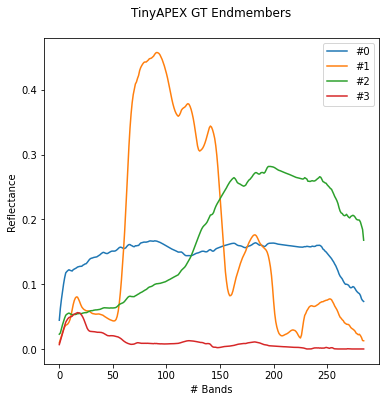

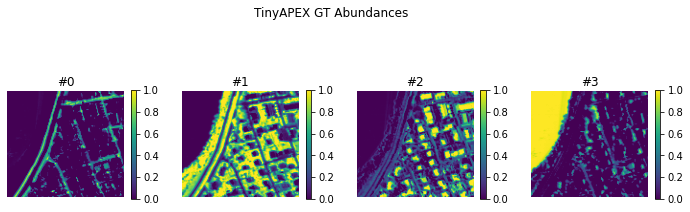

In [14]:
hsi = HSI("TinyAPEX.mat")
print(hsi)
hsi.plot_endmembers()
hsi.plot_abundances()

In [29]:
# Hyperparmameter settings
n_bands = hsi.L
num_endmembers = hsi.p
patch_size = 40
num_patches = 250
batch_size = 15
learning_rate = 0.003
#epochs = 320
epochs = 100

scale = 3 #scaling for softmax
l2 = 0
l1 = 0e-8
tv = 0e-8

activation = tf.keras.layers.LeakyReLU(0.02)
initializer = tf.keras.initializers.RandomNormal(0.0, 0.3)
regularizer = tf.keras.regularizers.l2(l2)

opt = tf.optimizers.RMSprop(learning_rate=learning_rate, decay=0.0)

# Load dataset
dataset = hsi.shortname
data, GT, _ = hsi()

# Reshape data
data = data.transpose()
data = data.reshape((hsi.H, hsi.W, hsi.L))

#e_filters is the number of featuremaps in the first hidden layer
#d_size is the decoder's filter size
#e_size is the size of the hidden layer's filter

params = {'e_filters': 48, 'e_size': 3, 'd_filters': n_bands, 'd_size': 13, 'activation': activation,
          'num_endmembers': num_endmembers, 'scale': scale, 'regularizer': regularizer,
          'initializer': initializer, 'l1': l1, 'tv': tv, 'patch_size': patch_size,
          'batch_size': batch_size, 'num_patches': num_patches, 'data': data, 'epochs': epochs}



## Run experiment

In [30]:
#num_runs = 25
num_runs = 1
plot_every_n = 0 #Plot endmembers and abundance maps every x epochs. Set to 0 when running experiments. 

for i in range(num_runs):
    print('Run number: '+str(i+1))

    patches = training_input_fn(data, patch_size, num_patches, batch_size)
    params = {'e_filters': 48, 'e_size': 3, 'd_filters': n_bands, 'd_size': 13, 'activation': activation,
              'num_endmembers': num_endmembers, 'scale': scale, 'regularizer': regularizer,
              'initializer': initializer, 'patch_size': patch_size,
              'batch_size': batch_size, 'num_patches': num_patches, 'data': data, 'epochs': epochs}
    autoencoder = Autoencoder(params)

    autoencoder.compile(opt, loss=SAD)
    autoencoder.train(callback=PlotWhileTraining(plot_every_n, data, GT), patches=patches)
    endmembers = autoencoder.getEndmembers()
    abundances = autoencoder.getAbundances(data)

Run number: 1
****************************************************************************************************

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


## Qualitative results

---


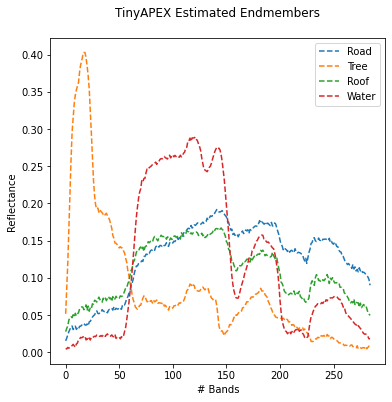

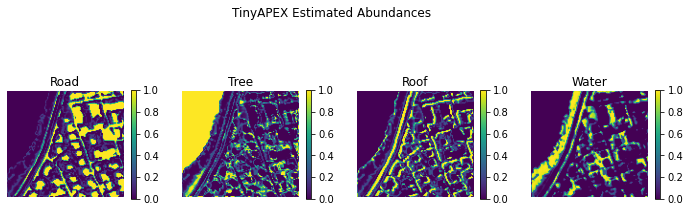

In [31]:
E0 = endmembers.T
A0 = abundances.transpose(2, 0, 1).reshape(hsi.p, hsi.N)

# Plot results
hsi.plot_endmembers(E0=E0)
hsi.plot_abundances(A0=A0)

## Endmembers alignment

---

At this stage we need to align the endmembers and the abundances to compute the RMSE and SAD metrics.

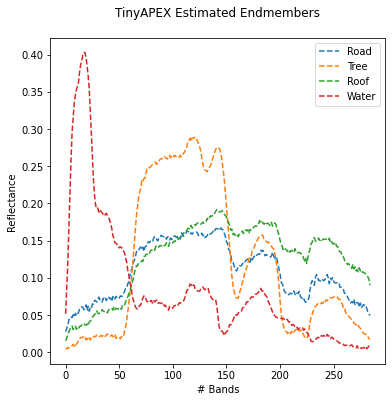

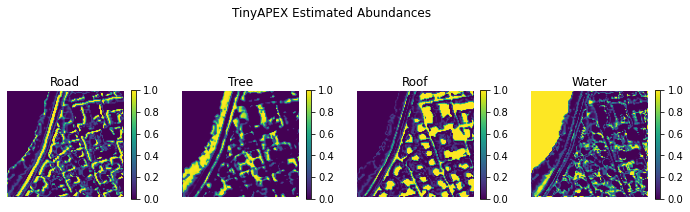

In [32]:
# Select a criterion to perform alignment
criterion = MSE()

# Select an aligner to perform alignment
aligner = Aligner(hsi=hsi, criterion=criterion)

A1 = aligner.fit_transform(A0)
E1 = aligner.transform_endmembers(E0)

# Plot alignment
hsi.plot_endmembers(E0=E1)
hsi.plot_abundances(A0=A1)

## Quantitative results

---

We are now in shape to compute the abundances RMSE and endmembers SAD.

In [33]:
# Instantiate metrics
rmse = RMSE()
sad = SADMetric()

# Compute final numbers
print(f"RMSE => {rmse(hsi.A, A1):.2f}")
print(f"SAD => {sad(hsi.E, E1):.2f}")

RMSE => 35.16
SAD => 12.37


### Results for each material

In [34]:
# Change the following line if you change dataset!
# Either comment out or describe each material name.
hsi.labels = ["Road", "Tree", "Roof", "Water"]
assert len(hsi.labels) == hsi.p

for ii, label in enumerate(hsi.labels):
    a, ahat = hsi.A[ii], A1[ii]
    print(f"RMSE ({label}) => {rmse(a, ahat):.2f}")

print("-" * 15)

for ii, label in enumerate(hsi.labels):
    e, ehat = hsi.E[:, ii][:, None], E1[:, ii][:, None]
    print(f"SAD ({label}) => {sad(e, ehat):.2f}")

RMSE (Road) => 38.90
RMSE (Tree) => 39.58
RMSE (Roof) => 27.42
RMSE (Water) => 33.38
---------------
SAD (Road) => 15.81
SAD (Tree) => 10.68
SAD (Roof) => 18.91
SAD (Water) => 4.09
